# Unet masks with scaled rectangle, keeping image dimensions ratio masks

In [34]:
import cv2
import numpy as np
import torch
import torchvision.transforms.functional as F
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from torchvision.io import decode_image

from wings.config import MODELS_DIR, RAW_DATA_DIR, IMG_FOLDER_SUFX, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from wings.dataset import MaskRectangleDataset
from wings.modeling.litnet import LitNet
from wings.modeling.loss import DiceLoss
from wings.utils import order_coords
from wings.visualizing.image_preprocess import mask_to_coords
from wings.visualizing.visualize import visualize_coords

countries = ['AT', 'GR', 'HR', 'HU', 'MD', 'PL', 'RO', 'SI']


In [35]:
square_size = 3
test_dataset = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "test_mask_dataset.pth",
    weights_only=False
)
max_n = len(test_dataset)
print(MaskRectangleDataset.__mro__)

(<class 'wings.dataset.MaskRectangleDataset'>, <class 'wings.dataset.MasksDataset'>, <class 'wings.dataset.WingsDatasetRectangleImages'>, <class 'wings.dataset.WingsDataset'>, <class 'torch.utils.data.dataset.Dataset'>, <class 'typing.Generic'>, <class 'object'>)


In [36]:
checkpoint_path = MODELS_DIR / 'unet-rectangle-epoch=08-val_loss=0.14-unet-training-rectangle_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()

Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


LitNet(
  (model): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNor

In [37]:
image, mask, orig_labels, orig_size = test_dataset[0]
print(image.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


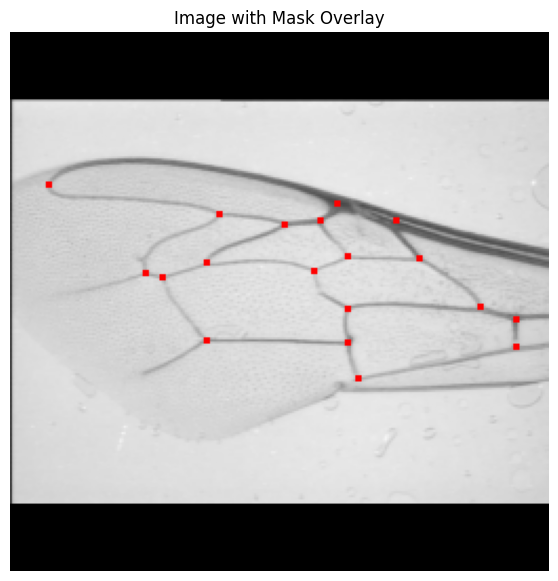

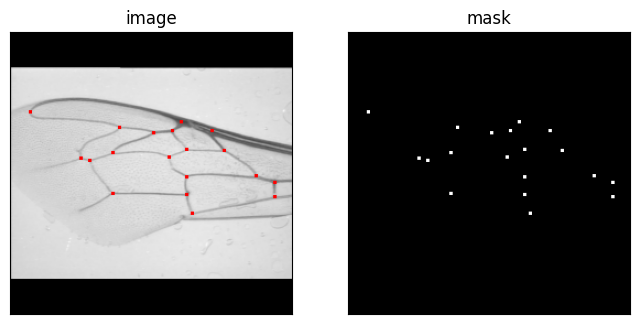

In [38]:
n = np.random.randint(0, max_n)
image, label, _, _ = test_dataset[n]

# image_np = image.detach().cpu().numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
# image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
# image_bgr = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)

original_dataset = test_dataset.dataset  # this gives you the original dataset
filename = original_dataset.coords_df.loc[test_dataset.indices[n], 'file']
output = model(image.cuda().unsqueeze(0))

country = filename.split('-', 1)[0]
img = decode_image(str(RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename))
img = F.resize(img, 255, interpolation=F.InterpolationMode.BILINEAR, antialias=True, max_size=256)
_, h, w = img.shape
if w >= h:
    pad_left = 0
    pad_top = (256 - h) // 2
    pad_right = 0
    pad_bottom = 256 - h - pad_top
else:
    pad_left = (256 - w) // 2
    pad_top = 0
    pad_right = 256 - w - pad_left
    pad_bottom = 0
img = F.pad(img, [pad_left, pad_top, pad_right, pad_bottom], padding_mode='constant', fill=0)
img = F.convert_image_dtype(img, torch.float)
img = img.numpy().transpose(1, 2, 0)
image_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

mask = torch.round(label).squeeze().detach().cpu().numpy()
labels = torch.round(label).squeeze().detach().cpu().numpy()

# Create boolean mask for white pixels in mask
white_areas = mask == 1
target_areas = labels == 1

# Set those areas to red (BGR: [0, 0, 255])
image_bgr[target_areas] = [0, 1, 0]
image_bgr[white_areas] = [0, 0, 1]

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show the result
plt.figure(figsize=(7, 7))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Image with Mask Overlay")
# plt.show()

_, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image_rgb, cmap="gray")
ax[0].set_title("image")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("mask")
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

# Predykcje z modelu

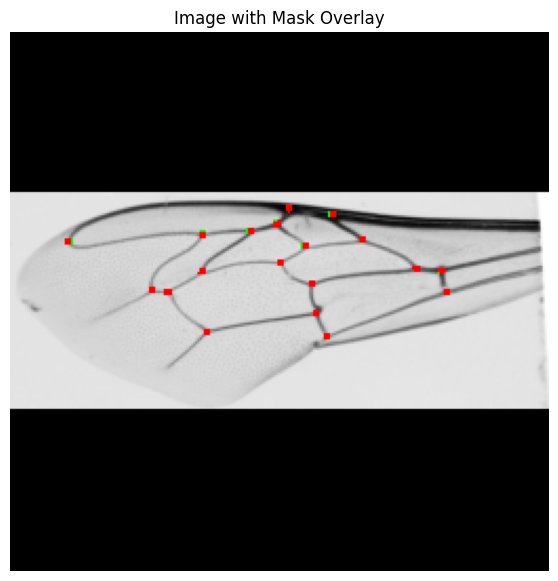

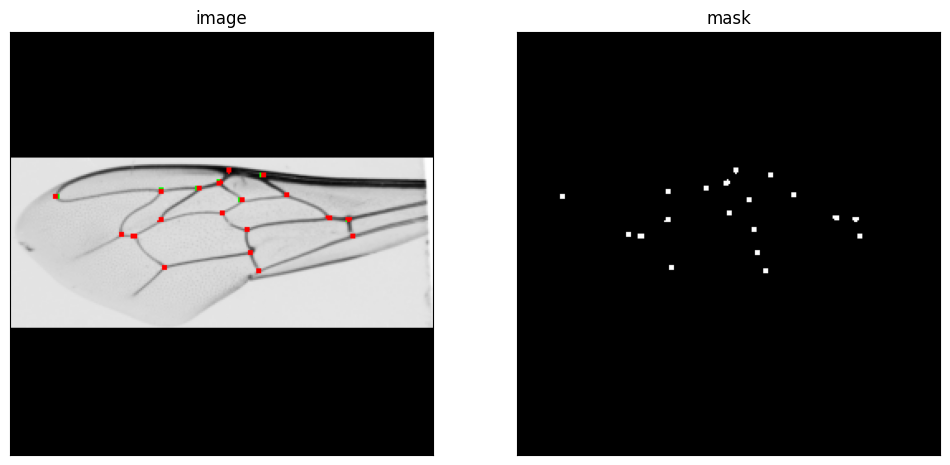

In [39]:
n = np.random.randint(0, max_n)
image, label, _, _ = test_dataset[n]

output = model(image.cuda().unsqueeze(0))

original_dataset = test_dataset.dataset  # this gives you the original dataset
filename = original_dataset.coords_df.loc[test_dataset.indices[n], 'file']
output = model(image.cuda().unsqueeze(0))

country = filename.split('-', 1)[0]
img = decode_image(str(RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename))
img = F.resize(img, 255, interpolation=F.InterpolationMode.BILINEAR, antialias=True, max_size=256)
_, h, w = img.shape
if w >= h:
    pad_left = 0
    pad_top = (256 - h) // 2
    pad_right = 0
    pad_bottom = 256 - h - pad_top
else:
    pad_left = (256 - w) // 2
    pad_top = 0
    pad_right = 256 - w - pad_left
    pad_bottom = 0
img = F.pad(img, [pad_left, pad_top, pad_right, pad_bottom], padding_mode='constant', fill=0)
img = F.convert_image_dtype(img, torch.float)
img = img.numpy().transpose(1, 2, 0)
image_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

mask = torch.round(output).squeeze().detach().cpu().numpy()
labels = torch.round(label).squeeze().detach().cpu().numpy()

# Create boolean mask for white pixels in mask
white_areas = mask == 1
target_areas = labels == 1

# Set those areas to red (BGR: [0, 0, 255])
image_bgr[target_areas] = [0, 1, 0]
image_bgr[white_areas] = [0, 0, 1]

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show the result
plt.figure(figsize=(7, 7))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Image with Mask Overlay")
# plt.show()

_, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(image_rgb, cmap="gray")
ax[0].set_title("image")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("mask")
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

# Calculate metrics

In [40]:
def unet_reverse_padding(padded_img: torch.Tensor, w_orig: int, h_orig: int) -> tuple[int, int, int, int]:
    """
    Reverses the padding added during unet_fit_rectangle_preprocess.
    Returns (pad_left, pad_top, pad_right, pad_bottom).
    Assumes the padded image is 256x256 and resizing used max_size=256 with max dim 255.
    """
    padded_h, padded_w = padded_img.shape
    assert padded_h == 256 and padded_w == 256, "Expected padded image to be 256x256"

    # Recompute resize scale from original dimensions
    if w_orig >= h_orig:
        scale = 255 / w_orig
    else:
        scale = 255 / h_orig

    resized_w = round(w_orig * scale)
    resized_h = round(h_orig * scale)

    pad_w_total = 256 - resized_w
    pad_h_total = 256 - resized_h

    pad_left = pad_w_total // 2
    pad_right = pad_w_total - pad_left

    pad_top = pad_h_total // 2
    pad_bottom = pad_h_total - pad_top

    return pad_left, pad_top, pad_right, pad_bottom


In [41]:
total_mse = 0
num_samples = 0
bad_masks = 0

for image, label, original_coords, orig_size in test_dataset:
    output = model(image.cuda().unsqueeze(0))
    mask = torch.round(output).squeeze().detach().cpu().numpy()
    try:
        mask_coords = mask_to_coords(mask, max_iter=1)

        mask_height, mask_width = mask.shape
        orig_width, orig_height = orig_size

        pad_left, pad_top, pad_right, pad_bottom = unet_reverse_padding(mask, orig_width, orig_height)

        mask_coords = [(x - pad_left, y - pad_bottom) for x, y in mask_coords]

        scale_x = orig_width / (mask_width - pad_right - pad_left)
        scale_y = orig_height / (mask_height - pad_top - pad_bottom)
        mask_coords = [(x * scale_x, y * scale_y) for x, y in mask_coords]

        mask_coords, original_coords = order_coords(mask_coords, original_coords)

        mse = mean_squared_error(original_coords, mask_coords)
        total_mse += mse
        num_samples += 1
    except Exception as e:
        bad_masks += 1

print(f"{bad_masks=}")
print(f"all masks:\t{bad_masks + num_samples}.")
print(f"bad rate:\t{bad_masks / (num_samples + bad_masks) * 100:.2f}%.")
average_mse = total_mse / (num_samples - bad_masks) if (num_samples - bad_masks) > 0 else float('nan')
print(f"Average MSE over the dataset: {average_mse:.3f}")


bad_masks=37
all masks:	2172.
bad rate:	1.70%.
Average MSE over the dataset: 2.979


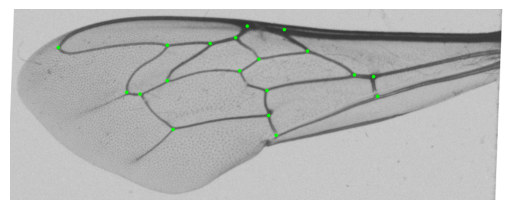

In [67]:
from wings.config import EXTERNAL_DATA_DIR

n = np.random.randint(0, max_n)
image, _, coords, orig_size = test_dataset[n]
original_dataset = test_dataset.dataset  # this gives you the original dataset
filename = original_dataset.coords_df.loc[test_dataset.indices[n], 'file']

output = model(image.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()

country = filename.split('-', 1)[0]
imgpath = RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename
img = cv2.imread(imgpath, cv2.IMREAD_COLOR)

try:
    mask_coords = mask_to_coords(mask, max_iter=1)

    mask_height, mask_width = mask.shape
    orig_width, orig_height = orig_size

    pad_left, pad_top, pad_right, pad_bottom = unet_reverse_padding(mask, orig_width, orig_height)

    mask_coords = [(x - pad_left, y - pad_bottom) for x, y in mask_coords]

    scale_x = orig_width / (mask_width - pad_right - pad_left)
    scale_y = orig_height / (mask_height - pad_top - pad_bottom)
    mask_coords = [(x * scale_x, y * scale_y) for x, y in mask_coords]

    mask_coords, original_coords = order_coords(mask_coords, coords)
    flat_coords = [coord for pair in mask_coords for coord in pair]  # Flatten list of tuples
    target_tensor = torch.tensor(flat_coords, dtype=torch.float32)

    # Visualize
    visualize_coords(img, target_tensor, spot_size=3)

except Exception as e:
    plt.imshow(mask)
    plt.axis('off')
    plt.show()
    print(e)
